## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)


# Arrays to store object points and image points from all the images.




In [2]:
# Step through the list and search for chessboard corners
def getCalibrationParameters(listFileimage, listX, listY):
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    images = []
    for i in range(len(listFileimage)):
        fname = 'camera_cal/' + listFileimage[i]
        x = listX[i]
        y = listY[i]
#        print ('i', i)
#        print ('fname', fname)
#        print ('x', x)
#        print ('y', y)
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        objp = np.zeros((x*y,3), np.float32)
        objp[:,:2] = np.mgrid[0:x,0:y].T.reshape(-1,2)
        ret, corners = cv2.findChessboardCorners(gray, (x,y),None)
        if ret == True:
            print ('chess detected')
            objpoints.append(objp)
            imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (x,y), corners, ret)
        images.append(img)
#        plt.imshow(img)
#        plt.show()
        
    return objpoints, imgpoints, images

In [3]:
objpoints, imgpoints, images = getCalibrationParameters(
    [
        'calibration1.jpg',  'calibration2.jpg',  'calibration3.jpg',
        'calibration4.jpg',  'calibration5.jpg',  'calibration6.jpg',
        'calibration7.jpg',  'calibration8.jpg',  'calibration9.jpg',
        'calibration10.jpg', 'calibration11.jpg', 'calibration12.jpg',
        'calibration13.jpg', 'calibration14.jpg', 'calibration15.jpg',
        'calibration16.jpg', 'calibration17.jpg', 'calibration18.jpg',
        'calibration19.jpg', 'calibration20.jpg'        
    ], 
    [
        9,9,9,    #  1  2  3 
        9,9,9,    #  4  5  6
        9,9,9,    #  7  8  9
        9,9,9,    # 10 11 12
        9,9,9,    # 13 14 15
        9,9,9,    # 16 17 18
        9,9       # 19 20
    ], 
    [
        5,6,6,    #  1  2  3
        6,5,6,    #  4  5  6 
        6,6,6,    #  7  8  9
        6,6,6,    # 10 11 12
        6,6,6,    # 13 14 15
        6,6,6,    # 16 17 18
        6,6       # 19 20
    ])

chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected
chess detected


In [4]:
#print ('objpoints', objpoints)
#print ('imgpoints', imgpoints)

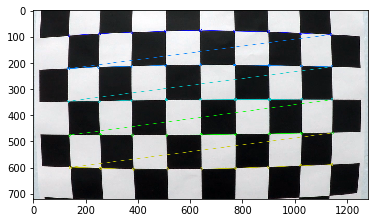

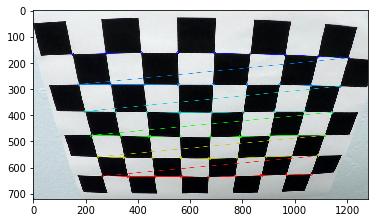

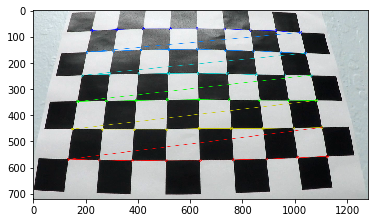

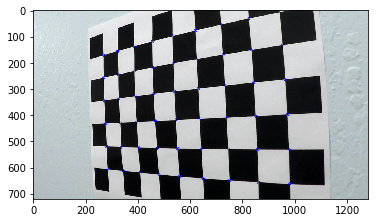

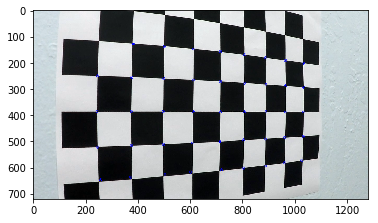

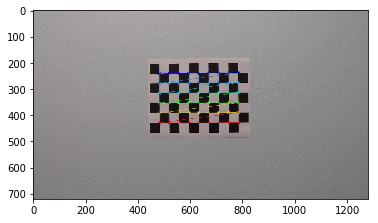

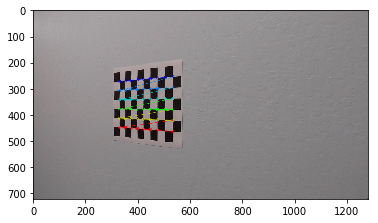

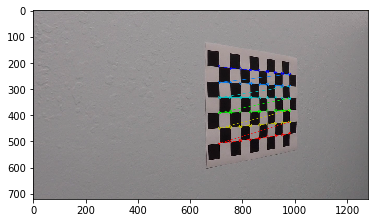

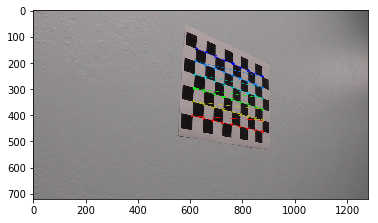

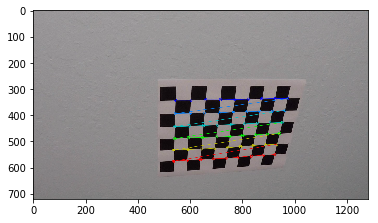

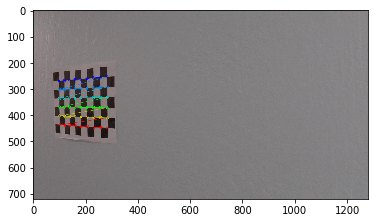

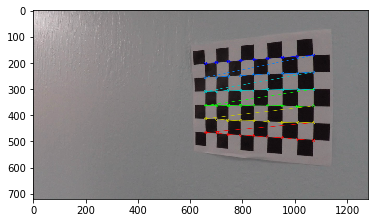

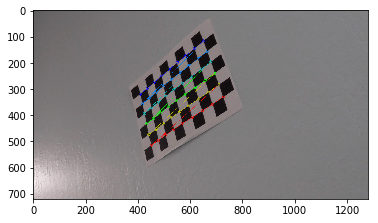

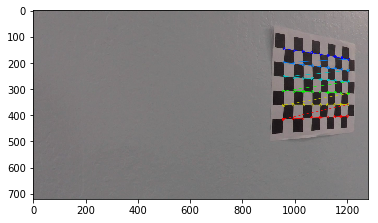

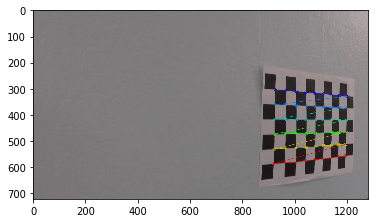

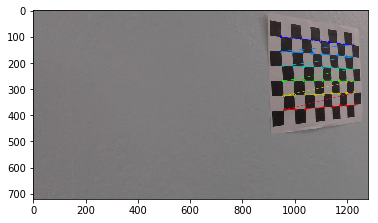

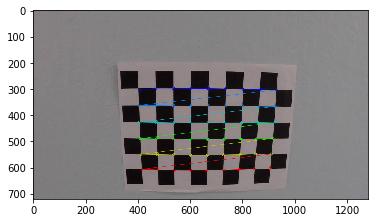

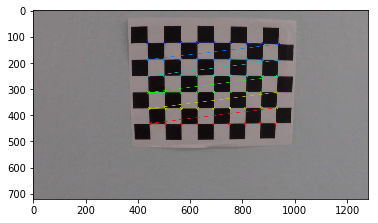

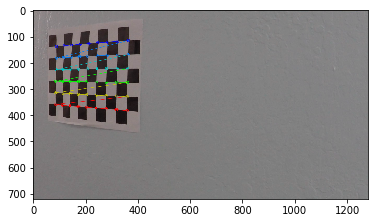

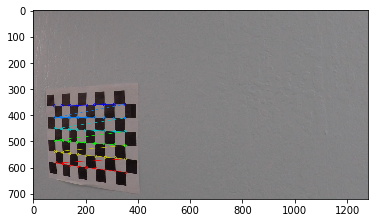

In [5]:
for img in images:
    plt.imshow(img)
    plt.show()

fname camera_cal/calibration2.jpg
chess detected


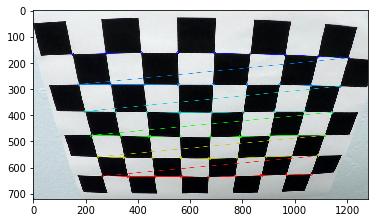

In [6]:
# Step through the list and search for chessboard corners
fname = 'camera_cal/calibration2.jpg'
print ('fname', fname)
img = cv2.imread(fname)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
if ret == True:
    print ('chess detected')
    objpoints.append(objp)
    imgpoints.append(corners)
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
plt.imshow(img)
plt.show()

## And so on and so forth...

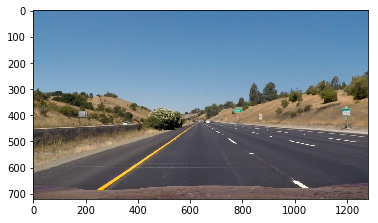

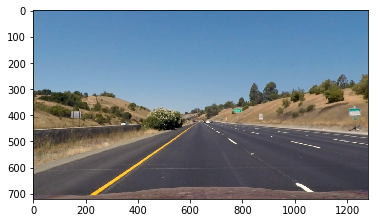

In [64]:
#img = cv2.imread('camera_cal/calibration3.jpg')
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)    
img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)
plt.show()

In [65]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]


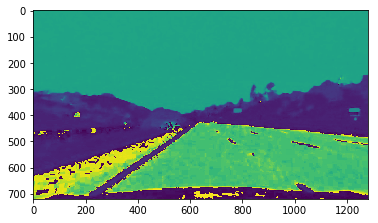

In [66]:
plt.imshow(h_channel)
plt.show()

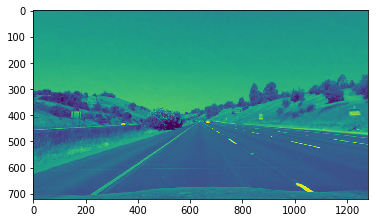

In [67]:
plt.imshow(l_channel)
plt.show()

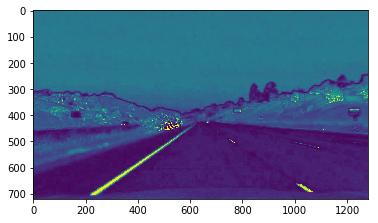

In [68]:
plt.imshow(s_channel)
plt.show()

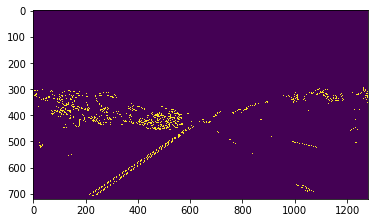

In [69]:
canny_image = cv2.Canny(s_channel, 50, 256)
plt.imshow(canny_image)
plt.show()

In [70]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [
            [ 750,  450],   # top right
            [1150,  720],   # bottom right
            [ 250,  720],   # bottom left
            [ 600,  450]    # top left

        ]
    )
    dst = np.float32(
        [
            [1150, 450],
            [1150, 720],
            [ 250, 720],
            [ 250, 450]
        ]
    )
    M = cv2.getPerspectiveTransform(src, dst)
#    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


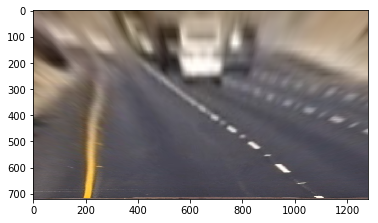

In [71]:
img = warp(img)
plt.imshow(img)
plt.show()